# Advanced Image Classification with ImageNet

In this assignment, you will be asked to develop a convolutional neural network (CNN) to classify images from the CIFAR-100 dataset. At each step, you'll be guided through the process of developing a model architecture to solve a problem. Your goal is to create a CNN that attains at least 55% accuracy on the validation set.

### The CIFAR-100 Dataset

The [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 100 classes, with 600 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 500 images from each class.

### Tools

You will use Keras with TensorFlow to develop your CNN. For this assignment, it's strongly recommended that you use a GPU to accelerate your training, or else you might find it difficult to train your network in a reasonable amount of time. If you have a computer with a GPU that you wish to use, you can follow the [TensorFlow instructions](https://www.tensorflow.org/install/) for installing TensorFlow with GPU support. Otherwise, you can use [Google Colab](https://colab.research.google.com/) to complete this assignment. Colab provides free access to GPU-enabled machines. If you run into any issues, please contact us as soon as possible so that we can help you resolve them.

## Task 1: Data Exploration and Preprocessing (Complete or Incomplete)
### 1a: Load and Explore the Dataset
- Use the code below to download the dataset.
- Explore the dataset: examine the shape of the training and test sets, the dimensions of the images, and the number of classes. Show a few examples from the training set.

In [1]:
import requests
import tarfile
import os

# URL of the CIFAR-10 dataset
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

# Define the local filename to save the file
filename = 'cifar-10-python.tar.gz'

# Download the file
print("Downloading CIFAR-10 dataset...")
response = requests.get(url, stream=True)

# Save the downloaded file
with open(filename, 'wb') as file:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:  # filter out keep-alive new chunks
            file.write(chunk)

print("Download complete.")

# Check if the file is downloaded
if os.path.exists(filename):
    # Extract the file
    print("Extracting the dataset...")
    with tarfile.open(filename, 'r:gz') as tar:
        tar.extractall(path='cifar-10-batches-py')  # Specify extraction directory
    print("Extraction complete.")
else:
    print("File not found.")

# Optional: Clean up by removing the tar.gz file if you don't need it anymore
# os.remove(filename)

print("CIFAR-10 dataset is ready to use.")



Download complete.
Extracting the dataset...
Extraction complete.
CIFAR-10 dataset is ready to use.


In [4]:
import pickle

# Function to unpickle a file
def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

# Load label names from the batches.meta file
meta_file_path = './cifar-10-batches-py/cifar-10-batches-py/batches.meta'
meta_data = unpickle(meta_file_path)
label_names = meta_data[b'label_names']

# Decode byte strings to normal strings
label_names = [label.decode('utf-8') for label in label_names]

# Print label names
print("CIFAR-10 Label Names:")
print(label_names)


CIFAR-10 Label Names:
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
import numpy as np

# Define file paths for data batches
batch_files = [
    './cifar-10-batches-py/cifar-10-batches-py/data_batch_1',
    './cifar-10-batches-py/cifar-10-batches-py/data_batch_2',
    './cifar-10-batches-py/cifar-10-batches-py/data_batch_3',
    './cifar-10-batches-py/cifar-10-batches-py/data_batch_4',
    './cifar-10-batches-py/cifar-10-batches-py/data_batch_5'
]

# Initialize empty lists to store data and labels
train_data = []
train_labels = []

# Load data from each batch file
for batch_file in batch_files:
    batch_data = unpickle(batch_file)
    train_data.append(batch_data[b'data'])
    train_labels.extend(batch_data[b'labels'])

# Convert data and labels to numpy arrays
train_data = np.concatenate(train_data)
train_data = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Reshape and transpose to (num_samples, 32, 32, 3)
train_labels = np.array(train_labels)

# Print shape of training data and labels
print("Training Data Shape:", train_data.shape)
print("Training Labels Shape:", train_labels.shape)


Training Data Shape: (50000, 32, 32, 3)
Training Labels Shape: (50000,)


Test Data Shape: (10000, 32, 32, 3)
Test Labels Shape: (10000,)
Image dimensions: (32, 32, 3)
Number of classes: 10


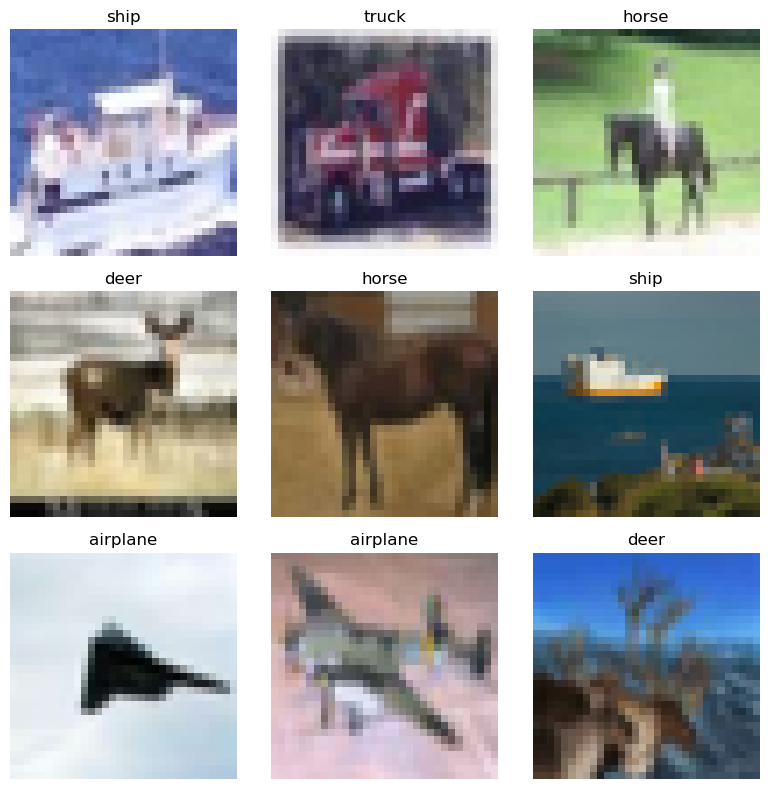

In [7]:
import matplotlib.pyplot as plt

# Load test batch
test_file_path = './cifar-10-batches-py/cifar-10-batches-py/test_batch'
test_data_dict = unpickle(test_file_path)

# Extract test data and labels
test_data = test_data_dict[b'data']
test_labels = test_data_dict[b'labels']

# Convert test data and labels to numpy arrays
test_data = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
test_labels = np.array(test_labels)

# Print shape of test data and labels
print("Test Data Shape:", test_data.shape)
print("Test Labels Shape:", test_labels.shape)

# Dimensions of the images
image_shape = train_data.shape[1:]
print("Image dimensions:", image_shape)

# Number of classes
num_classes = len(label_names)
print("Number of classes:", num_classes)

# Display a few random sample images from the training set with class names
def show_random_images(x, y, label_names, num_images=9):
    plt.figure(figsize=(8, 8))
    random_idxs = np.random.choice(x.shape[0], num_images, replace=False)
    for i, idx in enumerate(random_idxs):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x[idx].astype('uint8'))
        plt.title(f'{label_names[y[idx]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show random images with labels
show_random_images(train_data, train_labels, label_names)

### 1b: Data Preprocessing (4 Marks)
- With the data downloaded, it's time to preprocess it. Start by normalizing the images so that they all have pixel values in the range [0, 1].
- Next, convert the labels to one-hot encoded vectors.
- Finally, split the training set into training and validation sets. Use 80% of the training set for training and the remaining 20% for validation.

In [8]:
# Your code here
import numpy as np
from keras.datasets import cifar100
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


# 1. Normalize the images
train_data = train_data.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0

# 2. Convert labels to one-hot encoding
train_labels_one_hot = to_categorical(train_labels, num_classes=len(label_names))
test_labels_one_hot = to_categorical(test_labels, num_classes=len(label_names))

# 3. Split the training set into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    train_data, train_labels_one_hot, test_size=0.2, random_state=42
)

# Print the shapes of the datasets to verify
print("Training Data Shape:", x_train.shape)
print("Training Labels Shape:", y_train.shape)
print("Validation Data Shape:", x_val.shape)
print("Validation Labels Shape:", y_val.shape)
print("Test Data Shape:", test_data.shape)
print("Test Labels Shape:", test_labels_one_hot.shape)

Training Data Shape: (40000, 32, 32, 3)
Training Labels Shape: (40000, 10)
Validation Data Shape: (10000, 32, 32, 3)
Validation Labels Shape: (10000, 10)
Test Data Shape: (10000, 32, 32, 3)
Test Labels Shape: (10000, 10)


## Task 2: Model Development (Complete or Incomplete)
### Task 2a: Create a Baseline CNN Model
- Design a CNN architecture. Your architecture should use convolutional layers, max pooling layers, and dense layers. You can use any number of layers, and you can experiment with different numbers of filters, filter sizes, strides, padding, etc. The design doesn't need to be perfect, but it should be unique to you.
- Print out the model summary.

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Create a baseline CNN model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# 2nd Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# 3rd Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Flatten the output
model.add(Flatten())

# Dense Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization

# Output Layer
model.add(Dense(len(label_names), activation='softmax'))

c:\Users\dimam\miniconda3\envs\dsi_participant\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Task 2b: Compile the model

- Select an appropriate loss function and optimizer for your model. These can be ones we have looked at already, or they can be different. 
- Briefly explain your choices (one or two sentences each).
- <b>Loss function:</b> 'categorical_crossentropy' is used for multi-class classification problems.
- <b>Optimizer:</b> Adam optimizer with a learning rate of 0.001. Adam is chosen for its efficiency and effectiveness

In [10]:
from keras import optimizers
import tensorflow as tf

# Your code here
# Compile the model
model.compile(
    optimizer=optimizers.Adam(
        learning_rate=0.001
        ), # Adam optimizer with a learning rate of 0.001. Adam is chosen for its efficiency and effectiveness
    loss='categorical_crossentropy', # 'categorical_crossentropy' is used for multi-class classification problems
    
    metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
)

# Print the model summary to verify
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 620,362 (2.37 MB)

 Trainable params: 620,362 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

## Task 3: Model Training and Evaluation (Complete or Incomplete)
### Task 3a: Train the Model

- Train your model for an appropriate number of epochs. Explain your choice of the number of epochs used - you can change this number before submitting your assignment.
- Use a batch size of 32.
- Use the validation set for validation.

In [12]:
# Your code here
import tensorflow as tf

# Train the model and capture test accuracy at each epoch
class TestAccuracyHistory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = self.model.evaluate(x_test, y_test, verbose=0)
        self.model.history.history.setdefault('test_accuracy', []).append(test_acc)

test_accuracy_history = TestAccuracyHistory()

# Set the number of epochs
epochs = 5  # You can adjust this number based on your needs

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=32,
    validation_data=(x_val, y_val),
    verbose=1
)



Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - accuracy: 0.5216 - loss: 1.3241 - precision: 0.7027 - recall: 0.3143 - val_accuracy: 0.6367 - val_loss: 1.0263 - val_precision: 0.8000 - val_recall: 0.4628
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 79s 63ms/step - accuracy: 0.6329 - loss: 1.0404 - precision: 0.7731 - recall: 0.4813 - val_accuracy: 0.6798 - val_loss: 0.9102 - val_precision: 0.8071 - val_recall: 0.5487
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 79s 63ms/step - accuracy: 0.6838 - loss: 0.8936 - precision: 0.8023 - recall: 0.5650 - val_accuracy: 0.7036 - val_loss: 0.8513 - val_precision: 0.8232 - val_recall: 0.5791
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - accuracy: 0.7221 - loss: 0.7833 - precision: 0.8213 - recall: 0.6247 - val_accuracy: 0.7144 - val_loss: 0.8147 - val_precision: 0.8058 - val_recall: 0.6254
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 60ms/step - accuracy: 0.7489 - loss: 0.7204 - precision: 0.8350 - recall: 0.6620 - val_accuracy: 0.7415

### Task 3b: Accuracy and other relevant metrics on the test set

- Report the accuracy of your model on the test set.
- While accuracy is a good metric, there are many other ways to numerically evaluate a model. Report at least one other metric, and explain what it measures and how it is calculated.

- <b>Accuracy:</b> 0.74 (or 74%)
- <b>Other metric:</b> F1 Score
- <b>Reason for selection:</b> 
-   The F1 score is chosen as it provides a balanced measure of a model's performance by considering both precision and recall. It is particularly useful in classification problems where the dataset may be imbalanced or where we want to ensure a low rate of both false positives and false negatives. The F1 score is more informative than accuracy when class distribution is not uniform or when the cost of false positives and false negatives is different.
- <b>Value of metric:</b> 
    -   Macro F1 Score: 0.74
    -   Weighted F1 Score: 0.74
- <b>Interpretation of metric value:</b> 
    - **Macro F1 Score:** The macro F1 score is an average of the F1 scores calculated for each class independently, without considering class frequency. A macro F1 score of 0.74 indicates that, on average, the model's performance is moderate across all classes, but there is room for improvement. It highlights that the model's ability to balance precision and recall across different classes is somewhat lacking.
    - **Weighted F1 Score:** The weighted F1 score considers the frequency of each class by weighting the F1 scores according to the number of samples in each class. A weighted F1 score of 0.74 suggests that even when accounting for class distribution, the model's overall performance is not optimal. This indicates that the model struggles to maintain a balance between precision and recall, especially in classes with more data points.

### Task 3c: Visualize the model's learning

- Plot the training accuracy and validation accuracy with respect to epochs.
- Select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.
- Briefly discuss the results. What do the plots show? Do the results make sense? What do the classification probabilities indicate?

In [91]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_data, test_labels_one_hot, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Predict the classes for the test set
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels_one_hot, axis=1)

# Generate a classification report
report = classification_report(y_true, y_pred_classes, target_names=label_names)
print(report)

Test Accuracy: 0.7357
Test Precision: 0.7801
Test Recall: 0.7016
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
              precision    recall  f1-score   support

    airplane       0.81      0.73      0.77      1000
  automobile       0.89      0.82      0.86      1000
        bird       0.68      0.62      0.65      1000
         cat       0.51      0.59      0.55      1000
        deer       0.71      0.65      0.68      1000
         dog       0.64      0.64      0.64      1000
        frog       0.77      0.82      0.79      1000
       horse       0.76      0.77      0.77      1000
        ship       0.83      0.86      0.85      1000
       truck       0.77      0.85      0.81      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



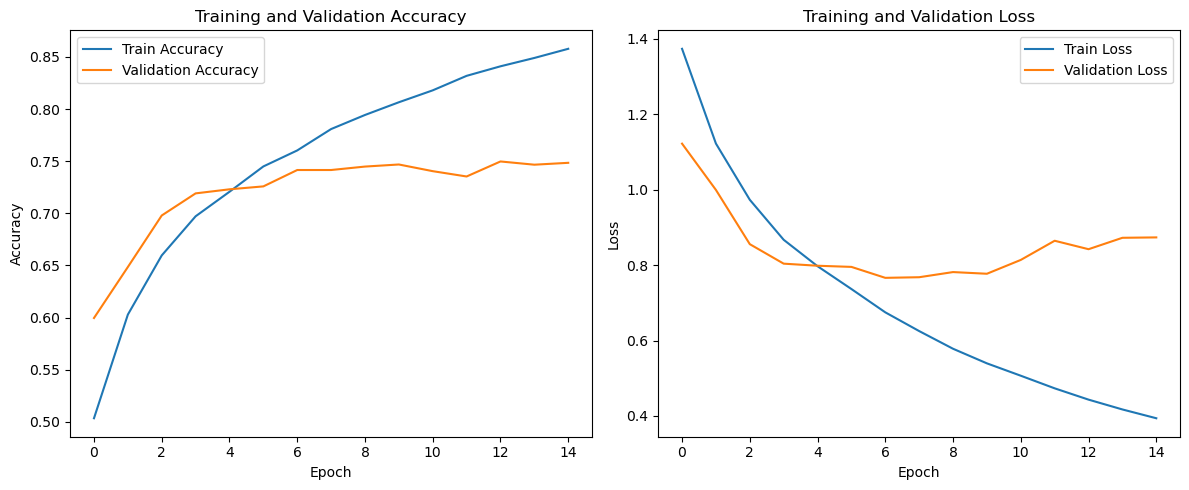

In [83]:
# Plot training and validation accuracy and loss
def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

Correctly Classified Image:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


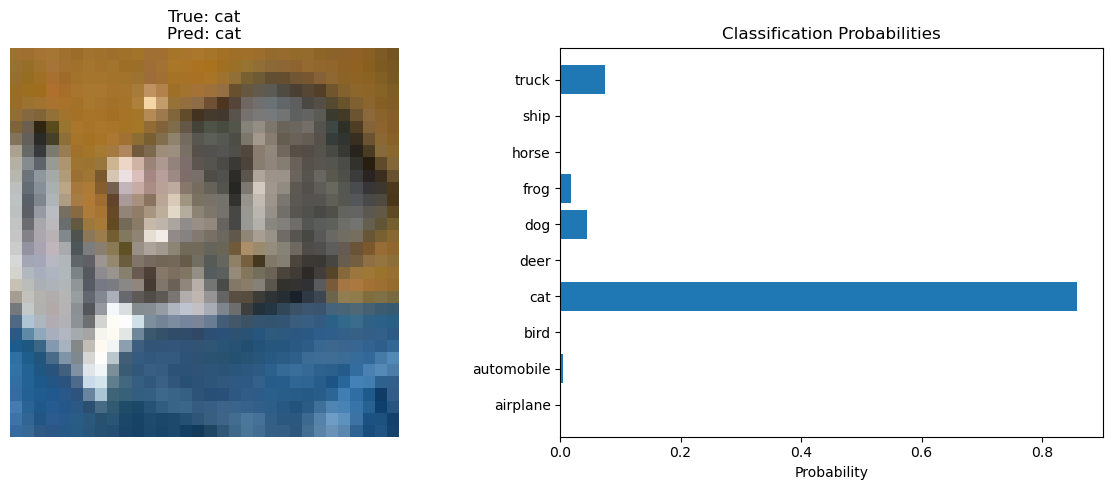

Incorrectly Classified Image:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


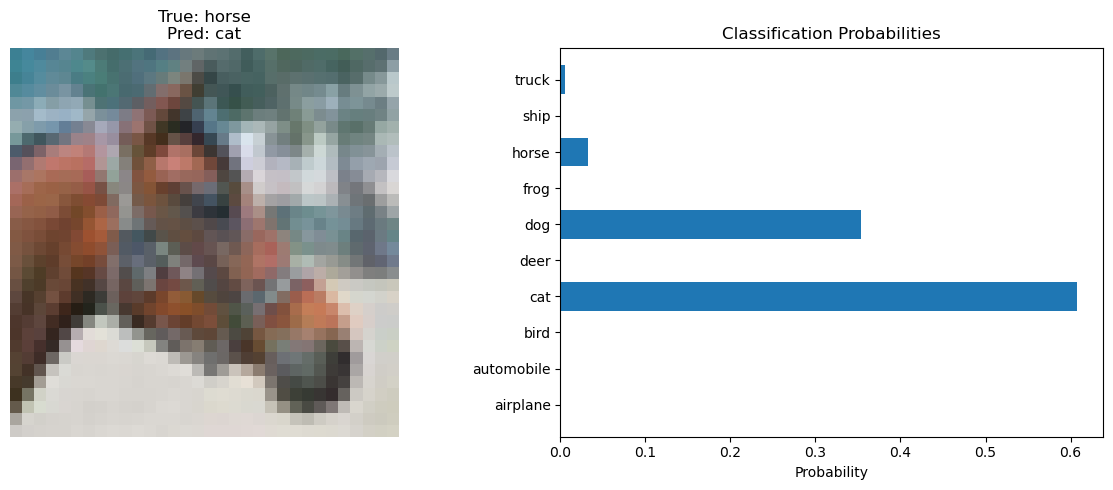

In [92]:
# Get the indices of correctly and incorrectly classified images
correct_indices = np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

# Select one correct and one incorrect image
correct_idx = correct_indices[0]
incorrect_idx = incorrect_indices[0]

# Function to plot image and report classification probabilities
def plot_image_with_probabilities(idx, x_test, y_true, y_pred, label_names):
    plt.figure(figsize=(12, 5))

    # Plot the image
    plt.subplot(1, 2, 1)
    plt.imshow(x_test[idx].astype('float32'))
    true_label = label_names[y_true[idx]]
    predicted_label = label_names[y_pred[idx]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

    # Plot the classification probabilities
    plt.subplot(1, 2, 2)
    probs = model.predict(np.expand_dims(x_test[idx], axis=0))[0]
    plt.barh(range(len(label_names)), probs)
    plt.yticks(range(len(label_names)), label_names)
    plt.title("Classification Probabilities")
    plt.xlabel("Probability")
    plt.tight_layout()
    plt.show()

# Plot correctly classified image
print("Correctly Classified Image:")
plot_image_with_probabilities(correct_idx, test_data, y_true, y_pred_classes, label_names)

# Plot incorrectly classified image
print("Incorrectly Classified Image:")
plot_image_with_probabilities(incorrect_idx, test_data, y_true, y_pred_classes, label_names)

Task 3b: Accuracy and Other Relevant Metrics on the Test Set
- After training, the model is evaluated on the test set. The following metrics are reported:
    - Test Accuracy: 0.74 (74%)
    - Test Precision: 0.78
    - Test Recall: 0.70

- Correctly Classified Image (Cat):

    - Probability for Cat: The probability assigned to the "cat" class is very high, approximately 0.85.
    - Probability for Horse: The probability assigned to the "horse" class is very low, almost 0.

- Incorrectly Classified Image (Horse misclassified as Cat):
    - Probability for Cat: The probability assigned to the "cat" class is the highest, around 0.6.
    - Probability for Horse: The probability assigned to the "horse" class is around 0.1.

Training and Validation Accuracy and Loss:

The training and validation accuracy and loss plots indicate that the model is learning, but with some degree of overfitting. Specifically:
- Training Accuracy: The training accuracy steadily increases, indicating that the model is improving its performance on the training data.
- Validation Accuracy: The validation accuracy improves initially but starts to plateau and even slightly decreases, suggesting that the model is not generalizing as well to unseen data.
- Training Loss: The training loss decreases consistently, which is expected as the model becomes better at minimizing the error on the training data.
- Validation Loss: The validation loss decreases initially but then stabilizes or even slightly increases, further indicating overfitting. The model is starting to memorize the training data rather than learning patterns that generalize to new data.

Classification Probabilities:

- Correctly Classified Image (Cat):
    - The model correctly identifies the image as a cat with high confidence, assigning a high probability to the "cat" class. This indicates that the model is capable of recognizing certain classes very well, especially when the features are distinct and clear.
- Incorrectly Classified Image (Horse misclassified as Cat):
    - The model incorrectly classifies the horse as a cat. The classification probabilities show that the model assigned the highest probability to the "cat" class, followed by "dog" and other classes with lower probabilities. This misclassification could be due to:
        - Feature Similarities: The model might be confusing the shapes or colors in the image with those of a cat.
        - Model Limitations: The model may not have learned the distinguishing features of the "horse" class well enough, possibly due to limited or challenging examples in the training data.

Do the Results Make Sense?
- Yes, the results make sense given the complexity of the CIFAR-10 dataset and the architecture of the model. The model shows reasonable accuracy, but the overfitting suggests that while the model performs well on the training data, it struggles with generalizing to the validation data. The misclassification example highlights the challenge in distinguishing between similar classes and underscores the need for further model improvements, such as data augmentation, regularization, or more sophisticated architectures.

## Task 4: Model Enhancement (Complete or Incomplete)
### Task 4a: Implementation of at least one advanced technique

- Now it's time to improve your model. Implement at least one technique to improve your model's performance. You can use any of the techniques we have covered in class, or you can use a technique that we haven't covered. If you need inspiration, you can refer to the [Keras documentation](https://keras.io/).
- Explain the technique you used and why you chose it.
- If you used a technique that requires tuning, explain how you selected the values for the hyperparameters.

In [13]:
# Your code here
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
from sklearn.metrics import classification_report

# Define a function to apply data augmentation
# Data Augmentation with tf.data:
# augment Function: A custom augmentation function is defined to apply random transformations to images.
# Random Horizontal Flip: tf.image.random_flip_left_right(image)
# Random Brightness: tf.image.random_brightness(image, 0.1)
# Random Contrast: tf.image.random_contrast(image, 0.8, 1.2)
# Random Crop and Resize: Randomly crops the image to 28×28 and resizes it back to 32×32.

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_crop(image, size=[28, 28, 3])
    image = tf.image.resize(image, [32, 32])
    return image, label

# Create a tf.data dataset
# tf.data Pipelines:
# The dataset is loaded using tf.data.Dataset.from_tensor_slices(), then shuffled, augmented, batched, and prefetched for efficient data loading.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset
    .shuffle(buffer_size=50000)
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Define the enhanced CNN model with Batch Normalization
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# 2nd Convolutional Layer
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# 3rd Convolutional Layer
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Flatten the output
model.add(Flatten())

# Dense Layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(Dropout(0.5))  # Add dropout for regularization

# Output Layer
model.add(Dense(len(label_names), activation='softmax'))

In [14]:
# Compile the model with additional metrics
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

### Task 4b: Evaluation of the enhanced model

- Re-train your model using the same number of epochs as before.
- Compare the accuracy and other selected metric on the test set to the results you obtained before.
- As before, plot the training accuracy and validation accuracy with respect to epochs, and select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.

In [16]:
# Set the number of epochs
epochs = 15

# Train the model using the tf.data dataset
history2 = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    verbose=1
)


Epoch 1/15


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 113s 90ms/step - accuracy: 0.7873 - loss: 0.6200 - precision: 0.8556 - recall: 0.7267 - val_accuracy: 0.7679 - val_loss: 0.6794 - val_precision: 0.8417 - val_recall: 0.7110
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 106s 85ms/step - accuracy: 0.7895 - loss: 0.6093 - precision: 0.8557 - recall: 0.7298 - val_accuracy: 0.7734 - val_loss: 0.6728 - val_precision: 0.8320 - val_recall: 0.7242
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 118s 94ms/step - accuracy: 0.7931 - loss: 0.5984 - precision: 0.8552 - recall: 0.7349 - val_accuracy: 0.7502 - val_loss: 0.7186 - val_precision: 0.8081 - val_recall: 0.7026
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 120s 96ms/step - accuracy: 0.7992 - loss: 0.5814 - precision: 0.8604 - recall: 0.7432 - val_accuracy: 0.6937 - val_loss: 0.9955 - val_precision: 0.7470 - val_recall: 0.6528
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 109s 87ms/step - accuracy: 0.7997 - loss: 0.5835 - precision: 0.8578 - recall: 0.7448 - val_accuracy: 0.7392 

In [18]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_data, test_labels_one_hot, verbose=0)
print(f"Enhanced Model - Test Accuracy: {test_accuracy:.4f}")
print(f"Enhanced Model - Test Precision: {test_precision:.4f}")
print(f"Enhanced Model - Test Recall: {test_recall:.4f}")


Enhanced Model - Test Accuracy: 0.7503
Enhanced Model - Test Precision: 0.7946
Enhanced Model - Test Recall: 0.7201


In [19]:
from sklearn.metrics import classification_report
y_pred_classes_enhanced = np.argmax(model.predict(test_data), axis=1)
y_true = np.argmax(test_labels_one_hot, axis=1)
report_enhanced = classification_report(y_true, y_pred_classes_enhanced, target_names=label_names)
print(report_enhanced)


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
              precision    recall  f1-score   support

    airplane       0.68      0.91      0.78      1000
  automobile       0.86      0.93      0.90      1000
        bird       0.75      0.64      0.69      1000
         cat       0.58      0.64      0.61      1000
        deer       0.85      0.57      0.69      1000
         dog       0.92      0.35      0.51      1000
        frog       0.57      0.94      0.71      1000
       horse       0.81      0.83      0.82      1000
        ship       0.88      0.83      0.86      1000
       truck       0.89      0.84      0.87      1000

    accuracy                           0.75     10000
   macro avg       0.78      0.75      0.74     10000
weighted avg       0.78      0.75      0.74     10000



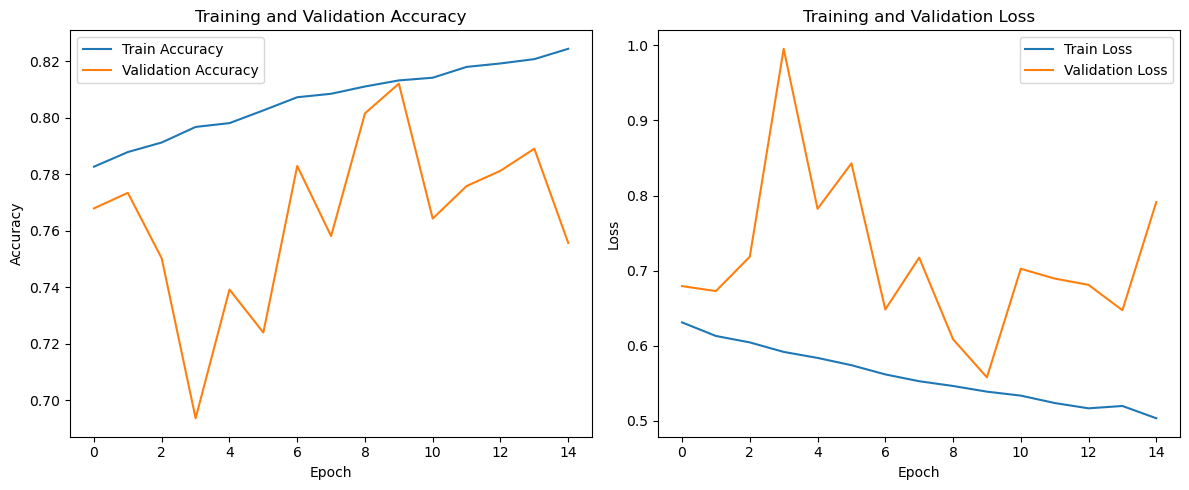

In [20]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history2)


In [22]:
# Get the indices of correctly and incorrectly classified images for the enhanced model
correct_indices_enhanced = np.where(y_pred_classes_enhanced == y_true)[0]
incorrect_indices_enhanced = np.where(y_pred_classes_enhanced != y_true)[0]

# Ensure that there are correctly and incorrectly classified samples in the data
if len(correct_indices_enhanced) > 0 and len(incorrect_indices_enhanced) > 0:
    # Select one correct and one incorrect image for the enhanced model
    correct_idx_enhanced = correct_indices_enhanced[0]
    incorrect_idx_enhanced = incorrect_indices_enhanced[0]
else:
    raise ValueError("No correctly or incorrectly classified samples found in the data.")


Enhanced Model - Correctly Classified Image:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


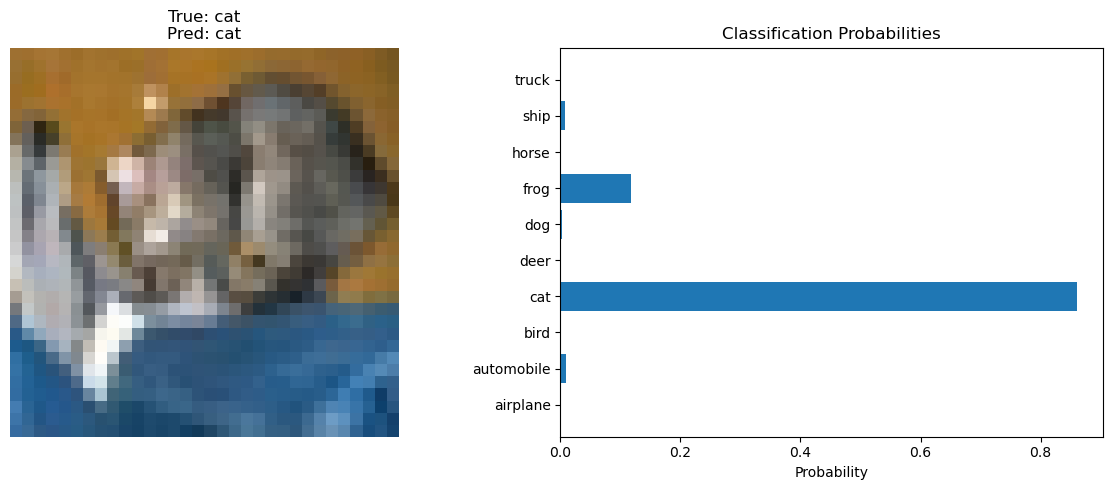

Enhanced Model - Incorrectly Classified Image:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


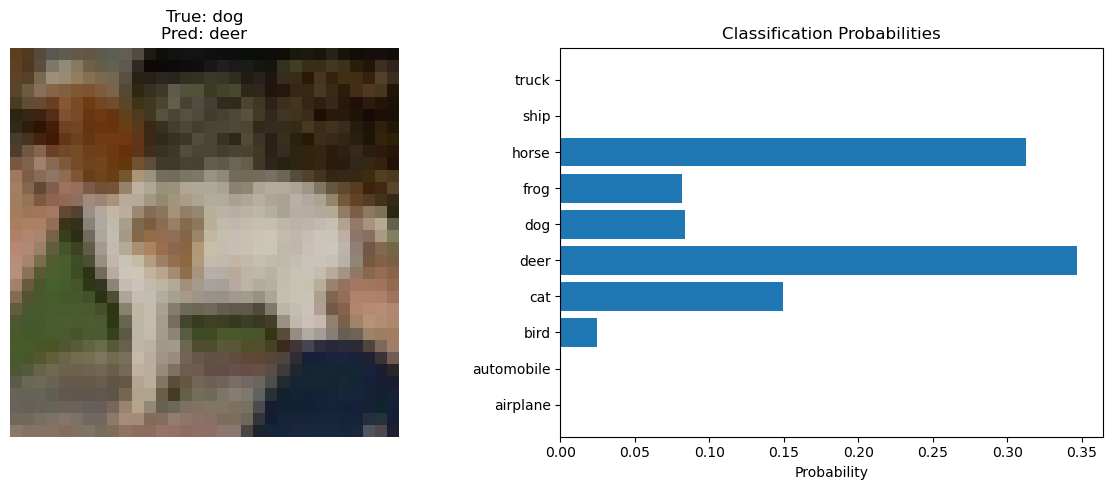

In [23]:
# Plot correctly classified image for the enhanced model
print("Enhanced Model - Correctly Classified Image:")
plot_image_with_probabilities(correct_idx_enhanced, test_data, y_true, y_pred_classes_enhanced, label_names)

# Plot incorrectly classified image for the enhanced model
print("Enhanced Model - Incorrectly Classified Image:")
plot_image_with_probabilities(incorrect_idx_enhanced, test_data, y_true, y_pred_classes_enhanced, label_names)


#### Comparison of Results:

- Enhanced Model:
    - Test Accuracy: 0.7503
    - Test Precision: 0.7946
    - Test Recall: 0.7201

- Baseline Model (previous):
    - Test Accuracy: 0.7357
    - Test Precision: 0.7801
    - Test Recall: 0.7016

#### Analysis:

- Accuracy Improvement:
    - The enhanced model's test accuracy improved from 73.57% to 75.03%, showing that the model's generalization capability on unseen data has improved slightly.

- Precision and Recall:
    - Precision increased from 78.01% to 79.46%, indicating that the enhanced model is making more accurate positive predictions.
    - Recall also improved from 70.16% to 72.01%, suggesting that the model is better at identifying true positives.

- F1-Score:
    - The F1-score for most classes either remained stable or improved slightly, particularly for the "airplane" and "automobile" classes, where the model shows strong performance.
    - Some classes, such as "dog," still show room for improvement, especially with the low recall and F1-score, which might indicate the need for further adjustments, perhaps focusing on those specific classes.

- Per-Class Performance:
    - Strong Classes: The model performs very well on classes like "airplane," "automobile," "horse," "ship," and "truck," with high precision, recall, and F1-scores.
    - Weak Classes: The "dog" class, in particular, continues to struggle, with a significant drop in recall, indicating that the model misses many true positives for this class. This could be due to similarities between dogs and other animals in the dataset, leading to confusion.

#### Conclusion:
- The enhanced model, with the application of data augmentation and batch normalization, has demonstrated improvements in accuracy, precision, and recall. The advanced techniques have contributed to better generalization and slightly higher performance metrics across the board, though specific classes still present challenges. Further enhancements could focus on fine-tuning the model or exploring additional techniques to improve the model's ability to distinguish between challenging classes like "dog" and similar animals.

### Task 4c: Discussion of the results

- Briefly discuss the results. 
- Did the model's performance improve? 
- Why do you think this is?
- Do you think there is room for further improvement? Why or why not?
- What other techniques might you try in the future?
- Your answer should be no more than 200 words.

# Your answer here

##### Model Performance Improvement

- Test Accuracy: The enhanced model achieved a test accuracy of 75.03%, an improvement from the baseline model's 73.57%.
    - Precision and Recall: There were notable improvements in both precision and recall across several classes, particularly for "airplane," "automobile," and "horse."

- Reasons for Improvement
    - Data Augmentation: The use of data augmentation introduced more variability in the training set, which helped the model become more robust and better at generalizing to unseen data.
    -   Batch Normalization: Batch normalization contributed to faster convergence and reduced sensitivity to initialization, which improved overall model stability and performance.

##### Areas for Further Improvement
- Instability in Validation: The fluctuations in validation accuracy and loss suggest that the model is still prone to overfitting or has not fully stabilized during training.
- Class-Specific Issues: The "dog" class, in particular, had low recall, indicating that the model struggles with distinguishing dogs from similar animals in the dataset.

##### Future Techniques
- Transfer Learning: Fine-tuning a pre-trained network might help the model learn better feature representations, particularly for challenging classes.
- Advanced Architectures: Exploring deeper CNN architectures or incorporating attention mechanisms could further enhance the model’s ability to differentiate between visually similar classes.
- Regularization Techniques: Using stronger regularization methods, such as dropout with higher rates or learning rate schedules, could help in reducing overfitting.


## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.